In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, pickle, time, warnings

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool

# Load in parameter transformations

In [226]:
# transform, p1, p2, lower bound, upper bound
param_trans = {}
a_dirichlet = 2
param_trans['shd'] = {'alpha1':('nexp',0,0,-3,3,'none'),
                      'alpha2':('nexp',0,0,-3,3,'none')}
param_trans[0] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1, -10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 0.1,  1.2,-10,10,'logistic')}
param_trans[1] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 1.2,3,-10,10,'logistic')}
param_trans[2] = {'w':('exp',0,0,-10,10,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-10,10,'none'),
                  'hz': ('logit_scaled', 3,  7.3,-10,10,'logistic')}

# Load data

In [227]:
# Load Sample
size = 2000
sample = {}; true_pars={}; latent_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = (hf['sample']['m'][...]>0)&(hf['sample']['m'][...]<33)
    print('%d/%d' % (np.sum(subset), len(subset)))
    subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset][subsample]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[str(j)]['w']*=size

99911/100000


# Generate model parameters

In [228]:
fid_pars = {'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']), 'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

fid_pars['free_pars'][0] = ['w', 'hz', 'fD']
fid_pars['free_pars'][1] = ['w', 'hz', 'fD']
fid_pars['free_pars'][2] = ['w', 'hz', 'fD']
fid_pars['free_pars']['shd'] = ['alpha1', 'alpha2']
ndim=np.sum([len(fid_pars['free_pars'][key]) for key in fid_pars['free_pars'].keys()])

fid_pars['fixed_pars'][0] = {'Mms':true_pars['Mms'], 'fD':1.-1e-15, 'alpha3':true_pars['0']['alpha3'],
                             'Mms1':true_pars['Mms1'], 'Mms2':true_pars['Mms2'],
                             'Mto':true_pars['0']['Mto']}
fid_pars['fixed_pars'][1] = copy(fid_pars['fixed_pars'][0]); fid_pars['fixed_pars'][2] = copy(fid_pars['fixed_pars'][0])
fid_pars['fixed_pars'][1]['Mto'] = true_pars['1']['Mto']
fid_pars['fixed_pars'][2]['Mto'] = true_pars['2']['Mto']

fid_pars['functions']={}; fid_pars['functions_inv']={}; fid_pars['jacobians']={}; bounds=[]
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['functions'][cmpt]={}; fid_pars['functions_inv'][cmpt]={}; fid_pars['jacobians'][cmpt]={}
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['functions'][cmpt][par], \
        fid_pars['functions_inv'][cmpt][par], \
        fid_pars['jacobians'][cmpt][par]=func_inv_jac[param_trans[cmpt][par][0]](*param_trans[cmpt][par][1:3])
        bounds.append([param_trans[cmpt][par][3], param_trans[cmpt][par][4]])
        params_i += 1;
bounds = np.array(bounds).T

In [229]:
fid_pars['priors'] = {}
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['priors'][cmpt]={};
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['priors'][cmpt][par] = param_trans[cmpt][par][5:]
        params_i += 1;

In [230]:
true_pars

{'0': {'Mto': array(4.8),
  'alpha3': array(-1.),
  'fD': array(0.94),
  'hz': array(0.9),
  'w': array(400.)},
 '1': {'Mto': array(3.14),
  'alpha3': array(-0.5),
  'fD': array(0.998),
  'hz': array(1.9),
  'w': array(600.)},
 '2': {'Mto': array(3.3),
  'alpha3': array(-0.6),
  'fD': array(0.995),
  'hz': array(4.6),
  'w': array(1000.)},
 'Mms': array(8.),
 'Mms1': array(9.),
 'Mms2': array(7.),
 'Mx': array(10.7),
 'N': array(100000),
 'R0': array(8.27),
 'alpha1': array(-0.15),
 'alpha2': array(-0.3),
 'theta_deg': array(60)}

In [231]:
true_params_f=[];
true_params=[]; 
for j in range(fid_pars['ncomponents']):
    for par in fid_pars['free_pars'][j]:
        true_params_f   += [fid_pars['functions_inv'][j][par](true_pars[str(j)][par]),]
        true_params += [true_pars[str(j)][par],]
for par in fid_pars['free_pars']['shd']:
    true_params_f += [fid_pars['functions_inv']['shd'][par](true_pars[par]),]
    true_params += [true_pars[par],]
true_params_f=np.array(true_params_f)
true_params=np.array(true_params)
true_params, true_params_f

(array([ 4.00e+02,  9.00e-01,  9.40e-01,  6.00e+02,  1.90e+00,  9.98e-01,
         1.00e+03,  4.60e+00,  9.95e-01, -1.50e-01, -3.00e-01]),
 array([ 5.99146455,  0.98082925,  2.75153531,  6.39692966, -0.45198512,
         6.2126061 ,  6.90775528, -0.52324814,  5.29330482, -1.89711998,
        -1.2039728 ]))

# Test model

In [232]:
p0 = np.array( [transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                -np.random.rand()*1,-np.random.rand()*1] )

p0 = transformations.logit(np.random.rand(ndim))

p0 = np.array([0.,0.,-1.,
               0.,0.,-1.,
               0.,0.,-1.,
               -1.,-1.])

In [233]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'],
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)),
                       sample['m'], np.log(sample['parallax_error'])))
fid_pars['models']=[dh_msto.log_expmodel_perr_grad, dh_msto.log_expmodel_perr_grad, dh_msto.log_halomodel_perr_grad]
poisson_kwargs_global = {'sample':sample_2d, 'model_prior':dh_msto.model_prior,
                         'logmodel': dh_msto.logmodel_perr_grad, 
                         'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 
                        'chunksize':100, 'ncores':2}

In [78]:
poisson_kwargs_global

{'bins': ([0, inf], [-inf, inf]),
 'chunksize': 100,
 'fid_pars': {'Mmax': array(10.7),
  'R0': array(8.27),
  'components': ['disk', 'disk', 'halo'],
  'fixed_pars': {0: {'Mms': array(8.),
    'Mms1': array(9.),
    'Mms2': array(7.),
    'Mto': array(4.8),
    'alpha3': array(-1.),
    'fD': 0.999999999999999},
   1: {'Mms': array(8.),
    'Mms1': array(9.),
    'Mms2': array(7.),
    'Mto': array(3.14),
    'alpha3': array(-1.),
    'fD': 0.999999999999999},
   2: {'Mms': array(8.),
    'Mms1': array(9.),
    'Mms2': array(7.),
    'Mto': array(3.3),
    'alpha3': array(-1.),
    'fD': 0.999999999999999}},
  'free_pars': {0: ['w', 'hz', 'fD'],
   1: ['w', 'hz', 'fD'],
   2: ['w', 'hz', 'fD'],
   'shd': ['alpha1', 'alpha2']},
  'functions': {0: {'fD': <function transformations.<lambda>.<locals>.<lambda>(p)>,
    'hz': <function transformations.<lambda>.<locals>.<lambda>(p)>,
    'w': <function transformations.<lambda>.<locals>.<lambda>(p)>},
   1: {'fD': <function transformations.<la

In [234]:
def poisson_like(params, bounds=None, grad=False):

    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad, bounds=bounds)
    else: 
        if not grad: prior=0.
        else: prior=(0.,0.)

    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    obj = poisson_kwargs['logmodel'](poisson_kwargs['sample'], params, gmm=poisson_kwargs['gmm'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    if not grad: return np.sum(obj) - integral + prior

    model_val = np.sum(obj[0]) - integral[0] + prior[0]
    model_grad = np.sum(obj[1], axis=1) - integral[1] + prior[1]
    return model_val, model_grad

In [235]:
global params_i

def poisson_like_parallel_func(ii):
    grad = poisson_kwargs_global['grad']
    output = poisson_kwargs_global['logmodel'](poisson_kwargs_global['sample'][:,ii:ii+poisson_kwargs_global['chunksize']].copy(),
                                            params_i,
                                            gmm=copy(poisson_kwargs_global['gmm']),
                                            fid_pars=copy(poisson_kwargs_global['fid_pars']),
                                            grad=grad)
    if not grad: return np.sum(obj)
    else: return np.sum(output[0]), np.sum(output[1], axis=1)
    
def poisson_like_parallel(params, bounds=None):
    
    global params_i
    params_i = params.copy()
    grad = poisson_kwargs_global['grad']
    
    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad, bounds=bounds)
    else: 
        if not grad: prior=0.
        else: prior=(0.,0.)

    logl_val = 0.
    if grad: logl_grad = np.zeros(len(params))
            
    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], 
                                                 fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    
    i_list = np.arange(0, poisson_kwargs_global['sample'].shape[1], poisson_kwargs_global['chunksize'])
    with Pool(poisson_kwargs['ncores']) as p:
        for logl_i in p.imap(poisson_like_parallel_func, i_list):
            if not grad: logl_val += logl_i
            if grad: 
                logl_val += logl_i[0]
                logl_grad += logl_i[1]
    
    if not grad: return logl_val - integral[0] + prior[0]
    return logl_val - integral[0] + prior[0], logl_grad - integral[1] + prior[1]

In [236]:
poisson_kwargs_global['grad']=True

In [97]:
%time poisson_like(p0, grad=True)

CPU times: user 516 ms, sys: 4 ms, total: 520 ms
Wall time: 520 ms


(-3801.307131675191,
 array([ 420.20729853,  134.07668613,  274.78849077,  634.19122287,
          39.54230852,  422.59775146,  942.60147861, -280.57647038,
         454.44862505,   70.64403734,    3.82927333]))

In [98]:
%time poisson_like_parallel(p0)

CPU times: user 8 ms, sys: 16 ms, total: 24 ms
Wall time: 928 ms


(-3801.3071316751916,
 array([ 420.20729853,  134.07668613,  274.78849077,  634.19122287,
          39.54230852,  422.59775146,  942.60147861, -280.57647038,
         454.44862505,   70.64403734,    3.82927333]))

In [99]:
model = lambda x: poisson_like(x, grad=False)
grad  = lambda x: poisson_like(x, grad=True)[1]

In [100]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

array([[ 420.20474211,  420.20729853],
       [ 134.09135136,  134.07668613],
       [ 274.78563425,  274.78849077],
       [ 634.19065555,  634.19122287],
       [  39.53573469,   39.54230852],
       [ 422.60126065,  422.59775146],
       [ 942.60485639,  942.60147861],
       [-279.67416827, -280.57647038],
       [ 454.44267016,  454.44862505],
       [  72.45944289,   70.64403734],
       [   3.56521923,    3.82927333]])

In [101]:
model = lambda x: poisson_like_parallel(x)[0]
grad  = lambda x: poisson_like_parallel(x)[1]

In [102]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

array([[ 420.20928959,  420.20729853],
       [ 134.1004463 ,  134.07668613],
       [ 274.79018172,  274.78849077],
       [ 634.1815606 ,  634.19122287],
       [  39.54937711,   39.54230852],
       [ 422.60580813,  422.59775146],
       [ 942.60485639,  942.60147861],
       [-279.67416827, -280.57647038],
       [ 454.45176511,  454.44862505],
       [  72.45944289,   70.64403734],
       [   3.56067176,    3.82927333]])

# Run Newton CG

In [237]:
from scipy.optimize import minimize

In [238]:
##Print callback function
def printx(Xi):
    global Nfeval
    global fout
    sys.stdout.write('At iterate {0}, {1}'.format(Nfeval, poisson_like(Xi)) + '\n')
    sys.stdout.write(str(Xi)+'\n')
    Nfeval += 1

In [239]:
def nll(x):
    lnl, grad = poisson_like(x, grad=True)
    return -lnl, -grad

In [106]:
p0 = np.array( [transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                transformations.logit(np.random.rand()),transformations.logit(np.random.rand()),-np.random.rand()*1,
                -np.random.rand()*1,-np.random.rand()*1] )

p0 = np.array([0.,0.,-1.,0.,
               0.,0.,-1.,0.,
               0.,0.,-1.,0.,
               -1.,-1.])

p0 = transformations.logit(np.random.rand(ndim))
p0 = np.random.normal(0,1,ndim)

In [110]:
p0, nll(p0)

(array([-1.26540199, -0.10396642,  0.34282964, -0.15772642,  0.93589459,
        -1.02864615,  1.05629682,  2.17651415,  0.37379262,  0.39673876,
        -1.12127779]),
 (2767.151521589184,
  array([ -261.19794279,     5.47292675,   -91.43134212,  -226.06214203,
            -8.42444248,  -110.04732834, -1508.72800391,    68.90464179,
          -405.83157055,   602.24172676,   -38.4484862 ])))

In [108]:
true_params_f, nll(true_params_f)

(array([ 5.99146455,  1.09861229,  2.75153531,  6.39692966, -0.45198512,
         6.2126061 ,  6.90775528, -0.52324814,  5.29330482, -1.89711998,
        -1.2039728 ]),
 (-9211.390622118324,
  array([ -5.50727638,   1.14282299,  -0.15213039,  -4.71065852,
          -0.17239004,   1.3628459 ,  10.2179349 , -20.15292345,
           1.86903404,   4.21298716,  -1.90173644])))

In [109]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 8509.176507419657
[-0.23991633 -0.12545361  0.70179698  0.72981306  0.96896968 -0.59659084
  6.97969313  1.90598858  1.96712237 -1.96771422 -0.97032572]
At iterate 2, 8773.338467770194
[-0.23618273 -0.12741338  0.7018482   0.73093001  0.96856369 -0.59567239
  7.86504112  1.83686623  2.11649388 -1.91077501 -0.96233498]
At iterate 3, 8859.48702054945
[-0.23544149 -0.12777862  0.70176184  0.7308803   0.96838465 -0.59545061
  7.61760605  1.80847686  2.16831275 -1.89675394 -0.95843476]
At iterate 4, 8979.147819329462
[-0.18978784 -0.1513221   0.69772817  0.73670625  0.95997507 -0.58524805
  7.60743355  0.52300625  2.96271253 -2.35153948 -0.75506795]
At iterate 5, 8988.206482266869
[-0.17781344 -0.15824215  0.69718557  0.73904685  0.95802782 -0.58338836
  7.59994862  0.42970237  3.0748765  -2.16281362 -0.75510904]
At iterate 6, 8995.07482625745
[-0.08195937 -0.21402294  0.69221478  0.76059585  0.94317475 -0.57063308
  7.59703345  0.53818619  3.57570323 -2.17308145 -0.85119024]


../models/disk_halo_mstogap.py:393: RuntimeWarning: invalid value encountered in true_divide
  grad_lambda[:,0] = -3/hz + abs_sin_lat/hz**2 * np.sum(dp_model_dhz*np.exp(Mag_norm), axis=0)/exp_log_p
../models/disk_halo_mstogap.py:411: RuntimeWarning: invalid value encountered in true_divide
  grad_lambda[:,1] = np.exp(Mag_norm[0])*((1/alpha3 + Mto+10-m_mu)*p_model[0] - 5/ln10*dp_model_dn[0])/exp_log_p
../models/disk_halo_mstogap.py:413: RuntimeWarning: invalid value encountered in true_divide
  grad_lambda[:,2] = ( p_model[0]*np.exp(Mag_norm[0])/(fD-1) + np.sum(p_model[1:]*np.exp(Mag_norm[1:]), axis=0)/fD )/exp_log_p
../models/disk_halo_mstogap.py:436: RuntimeWarning: invalid value encountered in true_divide
  - 5/ln10 * dalphag_dalpha1 * dp_model_dn[2])))/exp_log_p
../models/disk_halo_mstogap.py:444: RuntimeWarning: invalid value encountered in true_divide
  - 5/ln10 * dalphag_dalpha2 * dp_model_dn[2])))/exp_log_p
../models/disk_halo_mstogap.py:393: RuntimeWarning: invalid value encoun

         Current function value: -8995.074826
         Iterations: 6
         Function evaluations: 28
         Gradient evaluations: 57
         Hessian evaluations: 0


In [58]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 44447.60763522919
[ 7.51940536  2.64802754  2.47262421  0.09074082  1.97396167  0.59174372
  1.25514458 -1.13457508  0.53620958 -1.313382   -0.44672982]
At iterate 2, 51249.96771283628
[ 8.65135248  2.7922059   2.51763672  0.09888983  1.97568472  0.59450413
  1.41076036 -1.19998307  0.58805628 -1.17990044 -0.45348727]
At iterate 3, 52278.116514049296
[ 9.36015855  2.96974076  2.56946046  0.10410114  1.97701047  0.59634127
  1.58221611 -1.27435222  0.64372917 -1.03546585 -0.46235946]
At iterate 4, 53794.368000330775
[ 9.23441029  3.77286322  2.79283144  0.12312453  1.98221109  0.60319433
  2.5026419  -1.61603081  0.92490896 -0.50938324 -0.49844378]
At iterate 5, 59294.45222478233
[ 9.11502074  5.53259324  2.84314773  0.18450134  1.99732583  0.62476594
  7.95058403 -1.99754026  2.16416746 -2.59713037 -0.33582022]
At iterate 6, 61349.286180494164
[ 8.65238181  5.54808156  2.96206332  0.18469871  1.99737025  0.62505351
  8.85851789 -0.470063    2.30233601 -1.61260832 -0.20652

KeyboardInterrupt: 

In [34]:
true_params, true_params_f

(array([ 2.00e+03,  9.00e-01,  9.40e-01,  3.00e+03,  1.90e+00,  9.98e-01,
         5.00e+03,  4.60e+00,  9.95e-01, -1.50e-01, -3.00e-01]),
 array([ 7.60090246,  1.09861229,  2.75153531,  8.00636757, -0.45198512,
         6.2126061 ,  8.51719319, -0.52324814,  5.29330482, -1.89711998,
        -1.2039728 ]))

In [7]:
true_params, true_params_f

(array([ 2.00e+02,  9.00e-01,  9.40e-01,  3.00e+02,  1.90e+00,  9.98e-01,
         5.00e+02,  4.60e+00,  9.95e-01, -1.50e-01, -3.00e-01]),
 array([ 5.29831737,  1.09861229,  2.75153531,  5.70378247, -0.45198512,
         6.2126061 ,  6.2146081 , -0.52324814,  5.29330482, -1.89711998,
        -1.2039728 ]))

In [383]:
res

     fun: -9114.473105046893
     jac: array([ 0.01537997, -0.03937941,  0.00623833, -0.01971159, -0.01740806,
        0.009041  ,  0.02046982,  0.04048117,  0.00116462, -0.00516749,
       -0.00472826])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 51
    nhev: 0
     nit: 17
    njev: 315
  status: 2
 success: False
       x: array([ 4.01841999, -0.75379877,  1.30238593,  6.80615471, -1.66107461,
        4.89230176,  6.94794922, -0.39728925,  4.47106457, -1.81850411,
       -1.01688589])

In [342]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 3598.895787182455
[ 1.63624877  0.75507424  0.57109867  0.67120343 -0.09559155  0.60756163
  7.2821046   0.61782692  0.83389269 -1.81231508  0.10851004]At iterate 2, 3714.9285581788154
[ 1.63751846  0.75432765  0.57207958  0.67070505 -0.09568277  0.60789415
  6.90704201  0.58606947  0.99814073 -1.83250911  0.09245845]At iterate 3, 3843.883564935802
[ 1.66881821  0.74444813  0.58676435  0.66983404 -0.09693978  0.61232193
  6.93242751  0.37544015  2.13933082 -2.06682868 -0.09940385]At iterate 4, 3873.5971584437852
[ 1.72136958  0.72498583  0.61295375  0.66727917 -0.09916159  0.61885818
  6.90039239  0.39242968  2.88821645 -2.41640392 -0.47017023]At iterate 5, 3889.079356798249
[ 1.88374089  0.65581969  0.69761948  0.66195473 -0.10650763  0.63405112
  6.89579388  0.45232086  3.79593015 -2.17522113 -0.84492366]At iterate 6, 3912.245993384174
[ 3.87690995 -0.17398531  1.48781876  0.69598885 -0.19165654  0.69950227
  6.87008117  0.51383388  6.00449536 -2.23624388 -1.45646684]At

  6.44276908 -0.21792048  6.57931316 -2.43831362 -2.3077599 ]At iterate 51, 3957.990679445248
[ 5.90556104  4.62063125  3.80357347  1.32325    -0.75720326  0.3407291
  6.44446699 -0.21805416  6.57955907 -2.43826639 -2.30793893]At iterate 52, 3957.9919812221333
[ 5.90479396  4.62173677  3.80441993  1.32546681 -0.75890023  0.33944386
  6.44275728 -0.21792966  6.58018612 -2.43857717 -2.30812224]At iterate 53, 3957.9931779732497
[ 5.90559813  4.62221018  3.80478844  1.32642475 -0.75962496  0.33889612
  6.44462491 -0.21807665  6.58045449 -2.4385246  -2.30831821]At iterate 54, 3957.994219134876
[ 5.90476651  4.62311362  3.80548612  1.32824425 -0.76101948  0.33784064
  6.44275787 -0.21793868  6.58096803 -2.43881245 -2.30844708]At iterate 55, 3957.995405858067
[ 5.90550201  4.62354682  3.8058261   1.32912457 -0.76168556  0.33733758
  6.44446648 -0.21807316  6.58121403 -2.43876449 -2.30862652]At iterate 56, 3957.996721638865
[ 5.90472981  4.62464964  3.8066854   1.33135601 -0.7633941   0.336045

  6.44448538 -0.21826466  6.59955124 -2.44429528 -2.31619122]At iterate 100, 3958.0524748981707
[ 5.903933    4.65620439  3.83392696  1.39864057 -0.81484501  0.29752735
  6.4426459  -0.21812856  6.60018754 -2.44461929 -2.31636849]At iterate 101, 3958.0538393129714
[ 5.90478994  4.65665659  3.83435871  1.39965708 -0.81561744  0.29695581
  6.44464334 -0.21828521  6.6004558  -2.44455774 -2.31656919]At iterate 102, 3958.055036807622
[ 5.90389785  4.6575435   3.83520052  1.40164067 -0.81714572  0.29582316
  6.44264911 -0.21813612  6.60098356 -2.44485999 -2.31669483]At iterate 103, 3958.0563912895814
[ 5.90468712  4.65796037  3.83560168  1.40258147 -0.81786087  0.29529453
  6.44448934 -0.21828046  6.60123133 -2.44480347 -2.31687997]At iterate 104, 3958.057884952552
[ 5.90385197  4.65902938  3.83662494  1.40498279 -0.8197096   0.29392589
  6.44263862 -0.21814335  6.60186849 -2.44512868 -2.3170568 ]At iterate 105, 3958.0592643418836
[ 5.90471343  4.65947988  3.8370623   1.40600399 -0.8204861  

  6.44258311 -0.21828809  6.62053348 -2.45080694 -2.32466166]At iterate 149, 3958.1229258522603
[ 5.90377544  4.69007892  3.86946342  1.47820412 -0.87617319  0.25271749
  6.44471374 -0.21845477  6.62080306 -2.45073678 -2.32486835]At iterate 150, 3958.1242939935373
[ 5.90282159  4.69094937  3.87047123  1.48034384 -0.87784224  0.25151637
  6.44258931 -0.21829419  6.62134716 -2.45105493 -2.32499217]At iterate 151, 3958.1258311537313
[ 5.90366521  4.69135084  3.87094146  1.48133971 -0.87860814  0.250967
  6.44456363 -0.21844866  6.62159776 -2.45099018 -2.32518401]At iterate 152, 3958.127518291543
[ 5.90276627  4.69238861  3.87215261  1.48390057 -0.88060491  0.24953223
  6.4425804  -0.21829963  6.62224759 -2.45133064 -2.32535706]At iterate 153, 3958.1290813247597
[ 5.90368134  4.69281983  3.87266196  1.48497437 -0.88143129  0.2489404
  6.44472195 -0.21846714  6.62251736 -2.45125981 -2.32556429]At iterate 154, 3958.1304640369153
[ 5.90272247  4.69368879  3.87368444  1.48712588 -0.883112    0

  6.44483297 -0.21858559  6.64159384 -2.45710845 -2.33328354]At iterate 198, 3958.202350229732
[ 5.90153769  4.72338774  3.91201635  1.56367741 -0.94323352  0.20544013
  6.44258675 -0.21841412  6.64215643 -2.45744299 -2.33340736]At iterate 199, 3958.20406805218
[ 5.90243166  4.72377474  3.91256255  1.56471508 -0.94404961  0.2048789
  6.4446868  -0.21857818  6.64241106 -2.45737103 -2.33360645]At iterate 200, 3958.2059443622975
[ 5.90147321  4.72478306  3.91398278  1.56740233 -0.94619507  0.20340041
  6.44257942 -0.21841786  6.64307683 -2.4577276  -2.33377816]At iterate 201, 3958.207688484694
[ 5.90243758  4.72519653  3.91457093  1.56851421 -0.94707059  0.20279962
  6.44484485 -0.21859481  6.64334951 -2.4576494  -2.33399211]At iterate 202, 3958.2092399625813
[ 5.90142174  4.72604887  3.91578082  1.57079124 -0.948893    0.20154628
  6.44258928 -0.21842249  6.64391379 -2.45798531 -2.33411606]At iterate 203, 3958.2109719019863
[ 5.90231961  4.72643471  3.91633357  1.57183148 -0.94971315  0.

  6.44264944 -0.2185      6.6635071  -2.46406141 -2.34200686]At iterate 247, 3958.2903642486954
[ 5.90100042  4.75527857  3.96099088  1.65120823 -1.01404877  0.15796181
  6.44485005 -0.21867185  6.6637667  -2.46398434 -2.34221287]At iterate 248, 3958.2923986539195
[ 5.89999517  4.75625977  3.96263294  1.65396187 -1.01633578  0.15647476
  6.4426446  -0.21850235  6.66445193 -2.46435644 -2.3423867 ]At iterate 249, 3958.2942923294777
[ 5.90099761  4.75665703  3.96330286  1.65508679 -1.0172565   0.15587937
  6.44500799 -0.21868689  6.66472896 -2.46427315 -2.34260724]At iterate 250, 3958.2959822939297
[ 5.89993743  4.75749169  3.96470953  1.65743158 -1.01921041  0.15461247
  6.44265792 -0.21850584  6.66531347 -2.46462427 -2.34273389]At iterate 251, 3958.2978610489167
[ 5.90087335  4.75786379  3.965341    1.65848669 -1.02007574  0.15405445
  6.44486518 -0.21867821  6.66557354 -2.46454691 -2.34294043]At iterate 252, 3958.2999056604326
[ 5.89986503  4.7588427   3.96700141  1.66124179 -1.0223735

  6.44504085 -0.21873577  6.68573677 -2.47085645 -2.35106543]At iterate 296, 3958.3845730847015
[ 5.89838337  4.78685252  4.01815547  1.74105913 -1.09051872  0.11014778
  6.44278176 -0.21856077  6.68644326 -2.47124158 -2.35124536]At iterate 297, 3958.3865494602055
[ 5.89940497  4.78723514  4.01890337  1.74216113 -1.09147683  0.10957647
  6.44519837 -0.21874961  6.68672578 -2.47115675 -2.35147146]At iterate 298, 3958.388314609458
[ 5.8983219   4.78805014  4.02049731  1.74448532 -1.09353842  0.10834311
  6.44279827 -0.21856345  6.6873303  -2.47151996 -2.35160379]At iterate 299, 3958.3902723524075
[ 5.89927667  4.78840926  4.021203    1.74551941 -1.09444021  0.10780738
  6.44505749 -0.21874001  6.68759608 -2.47144117 -2.35181589]At iterate 300, 3958.392398946412
[ 5.89824535  4.78936224  4.02307672  1.74823806 -1.096856    0.10636778
  6.44279644 -0.21856477  6.68830437 -2.47182723 -2.35199652]At iterate 301, 3958.394378367518
[ 5.8992675   4.78974371  4.02383067  1.74933624 -1.09781675  

In [295]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 382.1533510967495
At iterate 2, 1417.8559603886442
At iterate 3, 3342.7086098593636
At iterate 4, 3856.3236068156734
At iterate 5, 3895.662692565562
At iterate 6, 3913.5752934549764
At iterate 7, 3921.107656502854
At iterate 8, 3921.880395782853
At iterate 9, 3923.3299392899216
At iterate 10, 3925.707531290581
At iterate 11, 3927.852789996343
At iterate 12, 3927.9902074533043
At iterate 13, 3928.2291579291873
At iterate 14, 3928.6011691844624
At iterate 15, 3928.9054650820626
At iterate 16, 3929.102004722321
At iterate 17, 3929.276938070457
At iterate 18, 3929.367395499419
At iterate 19, 3929.3703735462186
At iterate 20, 3929.3918575758535
At iterate 21, 3929.4245457653374
At iterate 22, 3929.465797099367
         Current function value: -3929.465797
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 701
         Hessian evaluations: 0


In [343]:
res

     fun: -3959.5666706320394
     jac: array([-0.06705799, -0.03714148, -0.02470247,  0.03652415,  0.04918254,
        0.00235685,  0.03558   , -0.085792  , -0.03812292,  0.26117587,
       -0.18593687])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 382
    nhev: 0
     nit: 322
    njev: 2146
  status: 2
 success: False
       x: array([ 5.88487021,  6.05180987,  5.87061082,  2.20342148, -3.88828526,
       -0.3914046 ,  6.44792849, -0.22244159,  7.9444138 , -2.96098234,
       -2.99394063])

# Sample p0 from prior

In [240]:
import emcee

In [241]:
def loglike(params):
    return dh_msto.model_prior(params, fid_pars=fid_pars, grad=False, bounds=bounds)

In [242]:
ndim=p0.shape[0]; nwalkers=ndim*4; nstep=1000

p0_walkers = np.random.normal(p0, 0.001, size=(nwalkers,ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

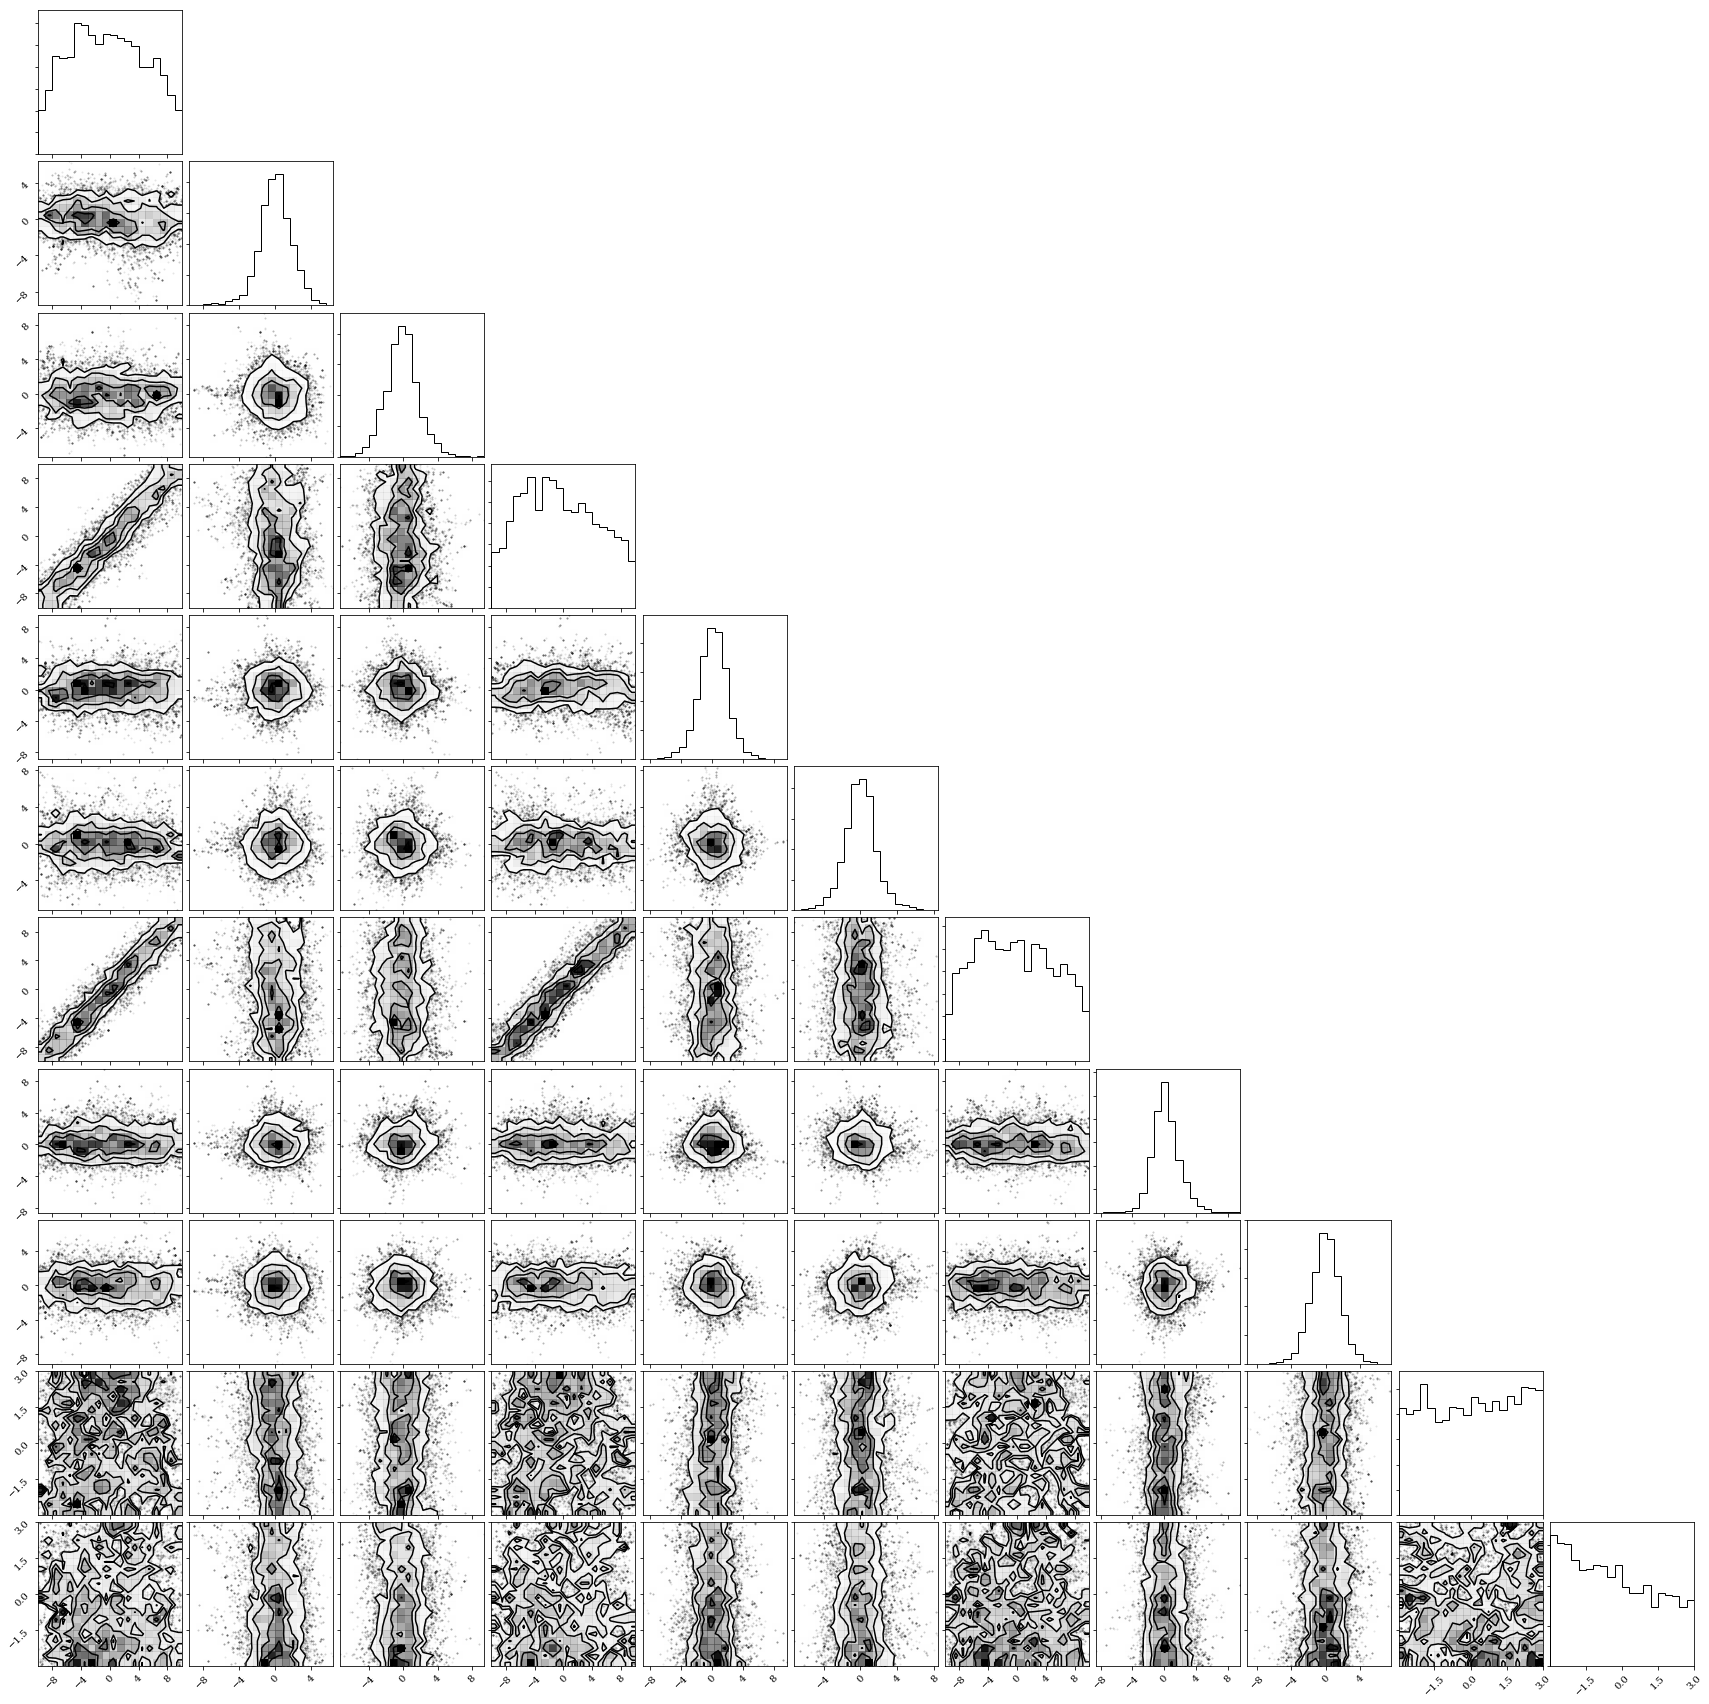

In [247]:
plotting.plot_corner(sampler.chain.copy(), truths=np.zeros(len(p0))-1000);

In [300]:
flatchain = sampler.chain[:,int(nstep/2)::,:].reshape(-1,ndim)
p0 = flatchain[np.random.choice(np.arange(flatchain.shape[0]), size=1)][0]

pars = dh_msto.combined_params(p0.copy(), fid_pars, ncomponents=fid_pars['ncomponents'])
p0[[0,3,6]] += np.log(sample_2d.shape[1]/np.sum([pars[j]['w'] for j in range(fid_pars['ncomponents'])]))

p0, nll(p0)

(array([ 7.45521566,  0.75732361, -4.0195995 ,  4.90806179, -1.28580261,
        -0.21259733,  4.910936  , -0.8979632 ,  2.08900551,  0.27901986,
        -1.71996196]),
 (-4933.607080856412,
  array([1190.87339808, -179.00466958, -333.27915151, -492.32206999,
           26.17210923, -341.88551059, -698.5513281 , -144.42575645,
           11.27076655,  478.77940778,  -46.71635518])))

In [301]:
true_params_f, nll(true_params_f)

(array([ 5.99146455,  0.98082925,  2.75153531,  6.39692966, -0.45198512,
         6.2126061 ,  6.90775528, -0.52324814,  5.29330482, -1.89711998,
        -1.2039728 ]),
 (-9107.687982628748,
  array([  3.88291873,  -4.93028791,   3.88785735,  -8.88607805,
          -0.12360275,   1.00698197,   5.00315932, -25.7457434 ,
           0.77405168,  -2.00516216,  -0.23421337])))

In [302]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 7731.478688830343
[ 7.01984952  1.07746483 -3.61547527  7.00780723 -1.47224449  1.14668369
  7.58919673 -0.33800198  2.05002185 -1.19016141 -1.51729382]
At iterate 2, 8533.39754475602
[ 6.29102614  1.09913607 -3.59685871  6.70862657 -1.49284215  1.26030355
  6.99867299 -0.30182744  2.09255716 -1.28510708 -1.47772697]
At iterate 3, 8865.022820318933
[ 5.28611169  1.15483886 -3.55522131  6.66560253 -1.54016802  1.63320578
  6.98597997 -0.28329384  2.22229823 -1.48494201 -1.37747718]
At iterate 4, 9033.841875935397
[ 4.29767472  1.21726692 -3.507966    6.75369771 -1.6666807   2.51381892
  6.9992057  -0.30233036  2.6207934  -1.82515773 -1.11042949]
At iterate 5, 9093.28226703225
[ 3.54745451  1.24855928 -3.45674558  6.9508482  -1.82817714  3.47061183
  6.87235768 -0.41042282  3.23375298 -1.56109005 -0.69129574]
At iterate 6, 9104.102007878031
[ 3.27931939  1.24635818 -3.40484105  6.82885658 -1.88154308  3.9910077
  6.96906758 -0.35914052  3.53061635 -1.73256098 -0.50380534]
A

In [222]:
Nfeval=1
res = minimize(nll, p0, method='Newton-CG', jac=True, callback=printx, options={'disp': True})

At iterate 1, 8562.341767339873
[ 2.31677282  0.55876732  1.01314431 -1.27474227  0.32229746  1.86513948
  8.11887872  0.5872641   1.83770778 -2.29812071  0.16581653]
At iterate 2, 8885.506538959979
[ 2.31804694  0.55748337  1.01316953 -1.27447184  0.32224571  1.86492283
  7.70467691  0.56742826  1.87222421 -2.29233881  0.1579999 ]
At iterate 3, 8948.895248859142
[ 2.39120298  0.51980682  1.01859193 -1.26827941  0.32115032  1.86057882
  7.59492694  0.21068047  2.47723839 -2.20743302 -0.0160611 ]
At iterate 4, 8980.2442592605
[ 2.72509978  0.35468522  1.0463307  -1.24533677  0.31708882  1.84459844
  7.58367596  0.23415032  3.05620453 -2.1918186  -0.61497804]
At iterate 5, 9008.115298077359
[ 3.62245758 -0.10080592  1.14716427 -1.19833139  0.30891147  1.81178832
  7.56819496  0.42910384  3.40230573 -1.94198691 -1.02544087]
At iterate 6, 9044.466257238417
[ 4.60300867 -0.4733371   1.32961206 -1.16893949  0.30401406  1.79125108
  7.53613889 -0.06737277  3.53597714 -2.23004619 -1.01609312]


In [187]:
p0 = np.array([4.,-0.8,-1.,0.3,-0.3])
nll(p0)

{0: {'fD': 0.2689414213699951, 'hz': 0.37203062264686504, 'Mms': array(8.), 'Mto': array(4.8), 'Mms1': array(9.), 'Mms2': array(7.), 'w': 54.598150033144236, 'alpha3': array(-1.), 'alpha1': -1.3498588075760032, 'alpha2': -0.7408182206817179}}


(20994.58009035652,
 array([-1.94540185e+03, -2.06367214e+04, -1.37817952e+03, -2.58692268e+02,
        -8.09673147e+00]))

# Invidual source gradient testing

In [149]:
isource=0
model = lambda x: poisson_kwargs_global['logmodel'](sample_2d, x, fid_pars=fid_pars, grad=False)[isource]
grad  = lambda x: poisson_kwargs_global['logmodel'](sample_2d, x, fid_pars=fid_pars, grad=True)[1][:,isource]

In [150]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

[ 0.  0. -1.  0.  0. -1.  0.  0. -1. -1. -1.] [ 1.          0.3        -0.36787944  1.          0.45       -0.36787944
  1.          1.075      -0.36787944 -0.36787944 -0.36787944]


array([[ 1.42517109e-01,  1.42518274e-01],
       [ 2.54443133e-01,  2.54438904e-01],
       [ 0.00000000e+00,  3.43633871e-50],
       [ 5.52504709e-01,  5.52505878e-01],
       [-6.95665747e-02, -6.95668001e-02],
       [ 0.00000000e+00,  2.23578165e-36],
       [ 3.04973824e-01,  3.04975849e-01],
       [ 1.28146382e-01,  1.28119817e-01],
       [ 0.00000000e+00,  1.51371304e-19],
       [ 2.71687117e-01, -1.69670768e+03],
       [-4.10316225e-02, -6.92702658e+01]])

In [160]:
isource=0
model = lambda x: poisson_kwargs_global['logmodel'](sample_2d[:,isource:isource+1], x, fid_pars=fid_pars, grad=False)[0]
grad  = lambda x: poisson_kwargs_global['logmodel'](sample_2d[:,isource:isource+1], x, fid_pars=fid_pars, grad=True)[1][:,0]
model = lambda x: poisson_kwargs_global['logmodel'](sample_2d, x, fid_pars=fid_pars, grad=False)#[isource]
grad  = lambda x: poisson_kwargs_global['logmodel'](sample_2d, x, fid_pars=fid_pars, grad=True)[1]#[:,isource]

In [159]:
grad(p0)

[ 0.  0. -1.  0.  0. -1.  0.  0. -1. -1. -1.] [ 1.          0.3        -0.36787944  1.          0.45       -0.36787944
  1.          1.075      -0.36787944 -0.36787944 -0.36787944]


array([ 1.42518274e-01,  2.54438904e-01,  3.43633871e-50,  5.52505878e-01,
       -6.95668001e-02,  2.23578165e-36,  3.04975849e-01,  1.28119817e-01,
        1.51371304e-19,  2.71272528e-01, -4.09447053e-02])

In [164]:
grad(p0)[:,0]

[ 0.  0. -1.  0.  0. -1.  0.  0. -1. -1. -1.] [ 1.          0.3        -0.36787944  1.          0.45       -0.36787944
  1.          1.075      -0.36787944 -0.36787944 -0.36787944]


array([ 1.42518274e-01,  2.54438904e-01,  3.43633871e-50,  5.52505878e-01,
       -6.95668001e-02,  2.23578165e-36,  3.04975849e-01,  1.28119817e-01,
        1.51371304e-19, -1.69670768e+03, -6.92702658e+01])

In [154]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

[ 0.  0. -1.  0.  0. -1.  0.  0. -1. -1. -1.] [ 1.          0.3        -0.36787944  1.          0.45       -0.36787944
  1.          1.075      -0.36787944 -0.36787944 -0.36787944]


array([[ 1.42517109e-01,  1.42518274e-01],
       [ 2.54443133e-01,  2.54438904e-01],
       [ 0.00000000e+00,  3.43633871e-50],
       [ 5.52504709e-01,  5.52505878e-01],
       [-6.95665747e-02, -6.95668001e-02],
       [ 0.00000000e+00,  2.23578165e-36],
       [ 3.04973824e-01,  3.04975849e-01],
       [ 1.28146382e-01,  1.28119817e-01],
       [ 0.00000000e+00,  1.51371304e-19],
       [ 2.71687117e-01, -1.69670768e+03],
       [-4.10316225e-02, -6.92702658e+01]])

In [181]:
isource=0
model = lambda x: dh_msto.logmodel_perr_grad(sample_2d[:,isource:isource+1], x, fid_pars=fid_pars, grad=False)[0]
grad  = lambda x: dh_msto.logmodel_perr_grad(sample_2d[:,isource:isource+1], x, fid_pars=fid_pars, grad=True)[1][:,0]

In [183]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

-6.554203076503464e-49 -1.2047312338610843
-1.0999855140655041e-35 -0.7742772605480664


array([[ 1.42517109e-01,  1.42518274e-01],
       [ 2.54443133e-01,  2.54438904e-01],
       [ 0.00000000e+00,  3.43633871e-50],
       [ 5.52504709e-01,  5.52505878e-01],
       [-6.95665747e-02, -6.95668001e-02],
       [ 0.00000000e+00,  2.23578165e-36],
       [ 3.04973824e-01,  3.04975849e-01],
       [ 1.28146382e-01,  1.28119817e-01],
       [ 0.00000000e+00,  1.51371304e-19],
       [ 2.71687117e-01,  2.71272528e-01],
       [-4.10316225e-02, -4.09447053e-02]])

In [184]:
isource=0
model = lambda x: dh_msto.logmodel_perr_grad(sample_2d, x, fid_pars=fid_pars, grad=False)[isource]
grad  = lambda x: dh_msto.logmodel_perr_grad(sample_2d, x, fid_pars=fid_pars, grad=True)[1][:,isource]

In [169]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

(1000, 3)


array([[ 1.42517109e-01,  1.42518274e-01],
       [ 2.54443133e-01,  2.54438904e-01],
       [ 0.00000000e+00,  3.43633871e-50],
       [ 5.52504709e-01,  5.52505878e-01],
       [-6.95665747e-02, -6.95668001e-02],
       [ 0.00000000e+00,  2.23578165e-36],
       [ 3.04973824e-01,  3.04975849e-01],
       [ 1.28146382e-01,  1.28119817e-01],
       [ 0.00000000e+00,  1.51371304e-19],
       [ 2.71687117e-01, -1.69670768e+03],
       [-4.10316225e-02, -6.92702658e+01]])

In [189]:
np.vstack((scipy.optimize.approx_fprime(p0, model, 1e-10), grad(p0))).T

array([[ 1.42517109e-01,  1.42518274e-01],
       [ 2.54443133e-01,  2.54438904e-01],
       [ 0.00000000e+00,  3.43633871e-50],
       [ 5.52504709e-01,  5.52505878e-01],
       [-6.95665747e-02, -6.95668001e-02],
       [ 0.00000000e+00,  2.23578165e-36],
       [ 3.04973824e-01,  3.04975849e-01],
       [ 1.28146382e-01,  1.28119817e-01],
       [ 0.00000000e+00,  1.51371304e-19],
       [ 2.71687117e-01,  2.71272528e-01],
       [-4.10316225e-02, -4.09447053e-02]])

# Plot z and M distributions

In [368]:
from pylab import cm

(0.5, 2000)

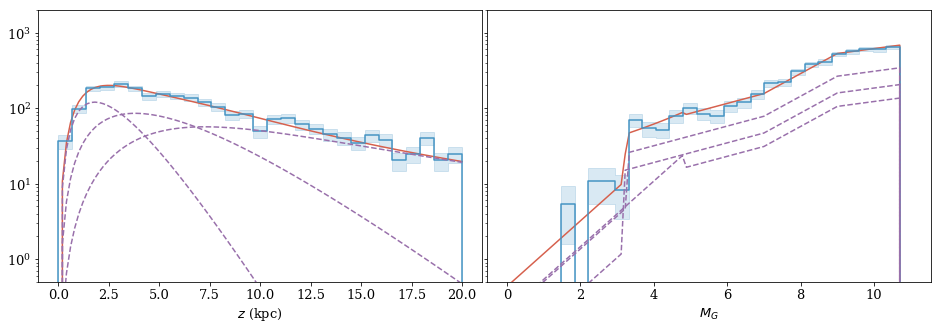

In [381]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['s']*sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)')

axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(0.5,2000)

(0.5, 2000)

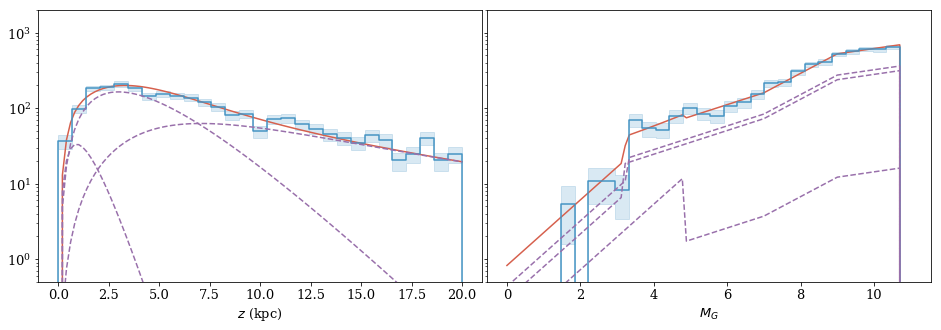

In [382]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, res['x'], fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['s']*sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)')

axes[0].plot(z_arr, dh_msto.z_model(z_arr, res['x'], fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, res['x'], fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, res['x'], fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(0.5,2000)